### Import Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

### Load Dataset

In [3]:
all_season_df = pd.read_csv("../data/processed/all_season.csv")
all_season_df.head()

,game_id,date,team_1,team_2,game_number,team_winner,patch_version,team_1_ban_1,team_1_ban_2,team_1_ban_3,...,team_1_pick_2,team_1_pick_3,team_1_pick_4,team_1_pick_5,team_2_pick_1,team_2_pick_2,team_2_pick_3,team_2_pick_4,team_2_pick_5,season
0,1,9-Aug-2024,tlid,fnoc,1,fnoc,1.9.06,fanny,zhask,hayabusa,...,edith,moskov,julian,minotaur,valentina,roger,arlott,chou,harith,14
1,2,9-Aug-2024,fnoc,tlid,2,fnoc,1.9.06,zhuxin,khufra,moskov,...,nolan,harith,minotaur,thamuz,roger,edith,arlott,vexana,joy,14
2,3,9-Aug-2024,dewa,evos,1,dewa,1.9.06,terizla,zhuxin,harith,...,edith,claude,julian,hylos,khufra,moskov,vexana,ruby,nolan,14
3,4,9-Aug-2024,dewa,evos,2,evos,1.9.06,terizla,zhuxin,harith,...,arlott,moskov,julian,x.borg,roger,zhask,hylos,guinevere,claude,14
4,5,9-Aug-2024,dewa,evos,3,dewa,1.9.06,zhuxin,terizla,zhask,...,hylos,moskov,julian,paquito,roger,harith,x.borg,guinevere,novaria,14


### Total Game by Patch Version

In [14]:
sns.set_theme(style="whitegrid", palette="RdGy")

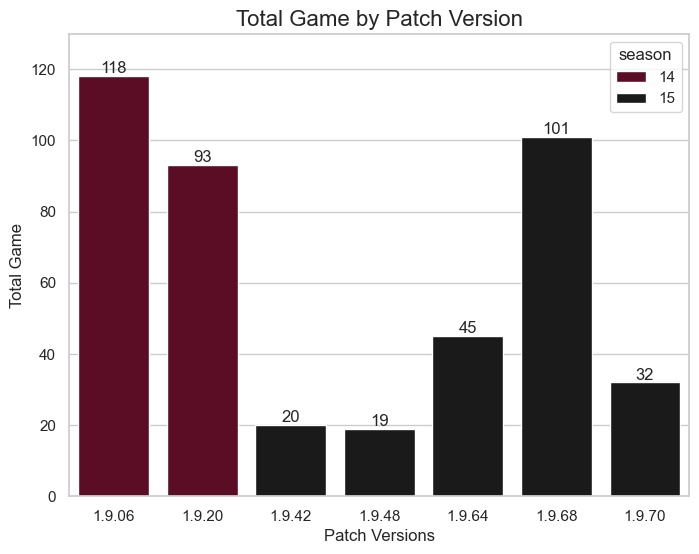

In [22]:
total_game_by_patch_version = all_season_df.groupby(["patch_version", "season"])["game_id"].count().reset_index(name="total_game")

plt.figure(figsize=(8, 6))
ax = sns.barplot(total_game_by_patch_version, x="patch_version", y="total_game", hue="season", palette="RdGy")
for container in ax.containers:
  ax.bar_label(container)

plt.title("Total Game by Patch Version", fontsize=16)
plt.xlabel("Patch Versions")
plt.ylabel("Total Game")
plt.ylim(0, max(total_game_by_patch_version["total_game"]) * 1.1)
plt.show()

### Heroes Stats

In [6]:
pick_stats, ban_list = [], []

for _, row in all_season_df.iterrows():
  for i in range(1, 6):
    # ban stats
    ban_list.append(row[f"team_1_ban_{i}"])
    ban_list.append(row[f"team_2_ban_{i}"])
    # pick stats
    team1_hero_picked = row[f"team_1_pick_{i}"]
    team2_hero_picked = row[f"team_2_pick_{i}"]
    is_team1_win = row["team_1"] == row["team_winner"]
    pick_stats.append({"hero": team1_hero_picked, "is_win": is_team1_win})
    pick_stats.append({"hero": team2_hero_picked, "is_win": not is_team1_win})

ban_stats_df = pd.DataFrame(ban_list, columns=["hero"])
ban_stats_df = ban_stats_df.value_counts().reset_index(name="ban")

pick_stats_df = pd.DataFrame(pick_stats)
pick_stats_df = pick_stats_df.groupby("hero")["is_win"].agg(pick="count", win="sum")

hero_stats_df = ban_stats_df.merge(pick_stats_df, on="hero", how="outer")
hero_stats_df.fillna(0, inplace=True)
hero_stats_df.head()

,hero,ban,pick,win
0,akai,7.0,17.0,7.0
1,alice,7.0,11.0,4.0
2,alpha,47.0,82.0,45.0
3,angela,19.0,28.0,16.0
4,arlott,34.0,60.0,31.0


In [7]:
TOTAL_GAMES = all_season_df["game_id"].nunique()

hero_stats_df["banrate"] = (hero_stats_df["ban"] / TOTAL_GAMES) * 100
hero_stats_df["pickrate"] = (hero_stats_df["pick"] / TOTAL_GAMES) * 100
hero_stats_df["winrate"] = (hero_stats_df["win"] / hero_stats_df["pick"]) * 100
hero_stats_df["winrate"] = hero_stats_df["winrate"].fillna(0)

hero_stats_df["banrate"] = hero_stats_df["banrate"].round(2)
hero_stats_df["pickrate"] = hero_stats_df["pickrate"].round(2)
hero_stats_df["winrate"] = hero_stats_df["winrate"].round(2)

hero_stats_df.to_csv("../data/processed/all_season_hero_stats.csv", index=False)
hero_stats_df.head()

,hero,ban,pick,win,banrate,pickrate,winrate
0,akai,7.0,17.0,7.0,1.64,3.97,41.18
1,alice,7.0,11.0,4.0,1.64,2.57,36.36
2,alpha,47.0,82.0,45.0,10.98,19.16,54.88
3,angela,19.0,28.0,16.0,4.44,6.54,57.14
4,arlott,34.0,60.0,31.0,7.94,14.02,51.67


### Top 10 Most Banned Heroes by Season

In [8]:
pick_list, ban_list = [], []

for _, row in all_season_df.iterrows():
  for i in range(1, 6):
    pick_list.append({"hero": row[f"team_1_pick_{i}"], "season": row["season"]})
    pick_list.append({"hero": row[f"team_2_pick_{i}"], "season": row["season"]})
    ban_list.append({"hero": row[f"team_1_ban_{i}"], "season": row["season"]})
    ban_list.append({"hero": row[f"team_2_ban_{i}"], "season": row["season"]})

ban_df = pd.DataFrame(ban_list).value_counts(["season", "hero"]).reset_index(name="ban_count")
ban_df.head()

,season,hero,ban_count
0,14,chip,204
1,15,fanny,174
2,14,fanny,163
3,15,luo yi,139
4,15,zhuxin,125


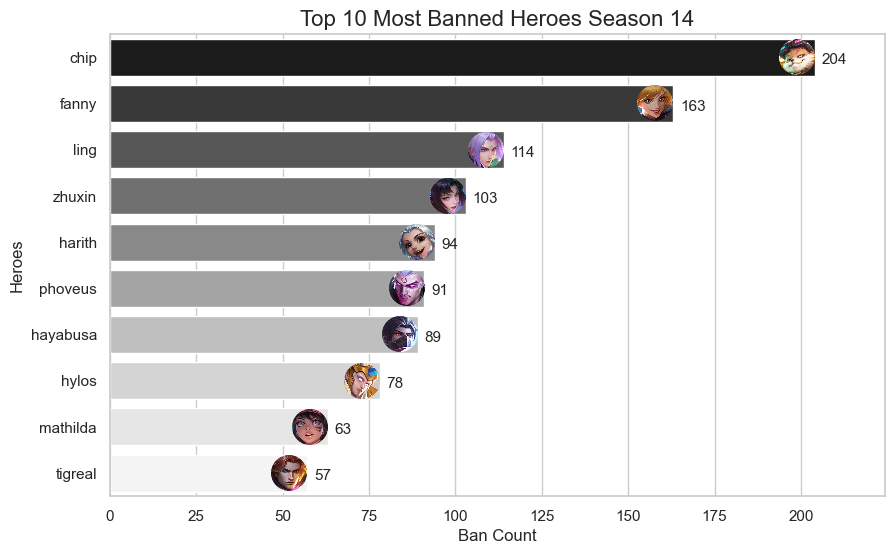

In [16]:
top_banned_s14_df = ban_df[ban_df["season"] == 14].nlargest(10, "ban_count").reset_index(drop=True)

plt.figure(figsize=(10, 6))
ax = sns.barplot(top_banned_s14_df, x="ban_count", y="hero", hue="hero", palette="Grays_r")
for i, row in top_banned_s14_df.iterrows():
  ax.text(row["ban_count"]+2, i+0.15, row["ban_count"], fontsize=11)
  img = plt.imread(f"../data/hero_images/{row['hero']}.png")
  im = OffsetImage(img, zoom=0.2)
  im.image.axes = ax
  ab = AnnotationBbox(im, (row["ban_count"], i), xybox=(-13, 0), frameon=False, xycoords="data", boxcoords="offset points", pad=0)
  ax.add_artist(ab)

plt.title("Top 10 Most Banned Heroes Season 14", fontsize=16)
plt.xlim(0, max(top_banned_s14_df["ban_count"]) * 1.1)
plt.xlabel("Ban Count")
plt.ylabel("Heroes")

plt.show()

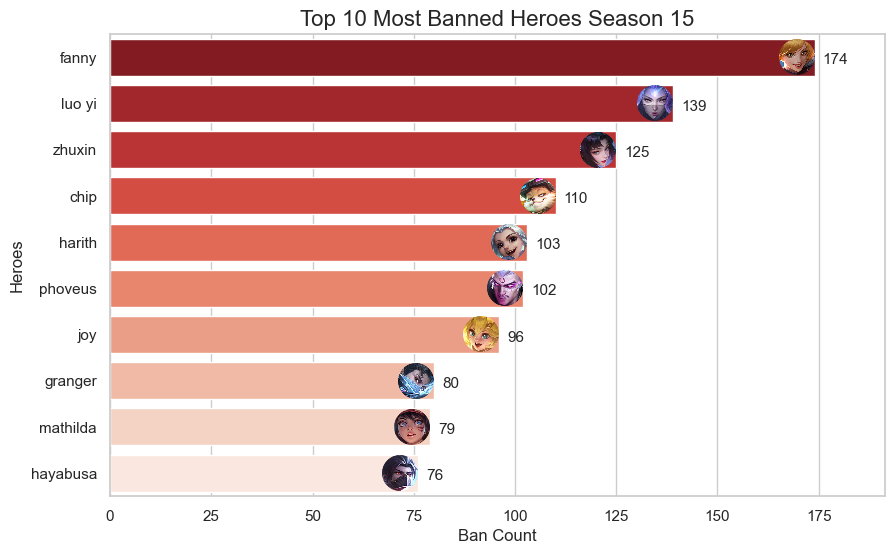

In [17]:
top_banned_s15_df = ban_df[ban_df["season"] == 15].nlargest(10, "ban_count").reset_index(drop=True)

plt.figure(figsize=(10, 6))
ax = sns.barplot(top_banned_s15_df, x="ban_count", y="hero", hue="hero", palette="Reds_r")
for i, row in top_banned_s15_df.iterrows():
  ax.text(row["ban_count"]+2, i+0.15, row["ban_count"], fontsize=11)
  img = plt.imread(f"../data/hero_images/{row['hero']}.png")
  im = OffsetImage(img, zoom=0.2)
  im.image.axes = ax
  ab = AnnotationBbox(im, (row["ban_count"], i), xybox=(-13, 0), frameon=False, xycoords="data", boxcoords="offset points", pad=0)
  ax.add_artist(ab)

plt.title("Top 10 Most Banned Heroes Season 15", fontsize=16)
plt.xlim(0, max(top_banned_s15_df["ban_count"]) * 1.1)
plt.xlabel("Ban Count")
plt.ylabel("Heroes")

plt.show()

### Top 10 Most Picked Heroes by Season

In [18]:
pick_df = pd.DataFrame(pick_list).value_counts(["season", "hero"]).reset_index(name="pick_count")
pick_df.head()

,season,hero,pick_count
0,15,granger,118
1,15,suyou,115
2,15,gatotkaca,105
3,14,edith,97
4,15,harith,96


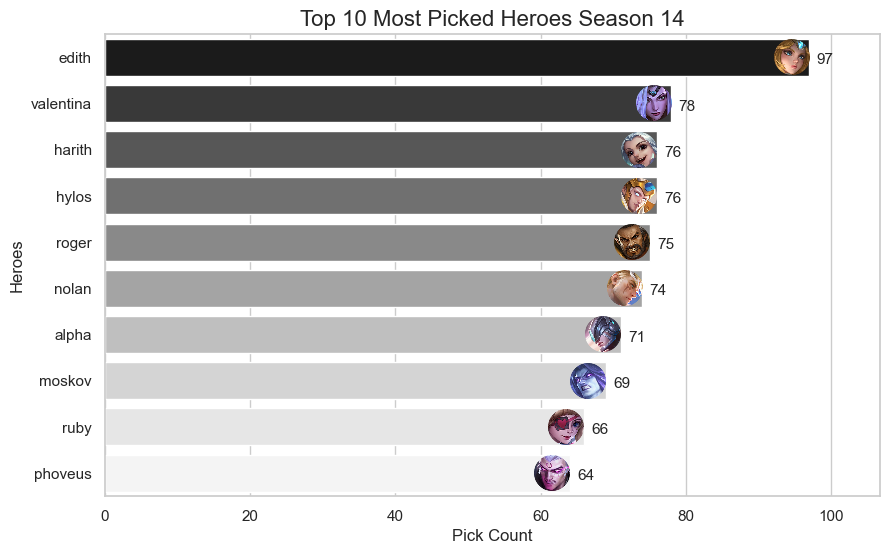

In [19]:
top_picked_s14_df = pick_df[pick_df["season"] == 14].nlargest(10, "pick_count").reset_index(drop=True)

plt.figure(figsize=(10, 6))
ax = sns.barplot(top_picked_s14_df, x="pick_count", y="hero", hue="hero", palette="Grays_r")
for i, row in top_picked_s14_df.iterrows():
  ax.text(row["pick_count"]+1, i+0.15, row["pick_count"], fontsize=11)
  img = plt.imread(f"../data/hero_images/{row['hero']}.png")
  im = OffsetImage(img, zoom=0.2)
  im.image.axes = ax
  ab = AnnotationBbox(im, (row["pick_count"], i), xybox=(-13, 0), frameon=False, xycoords="data", boxcoords="offset points", pad=0)
  ax.add_artist(ab)

plt.title("Top 10 Most Picked Heroes Season 14", fontsize=16)
plt.xlim(0, max(top_picked_s14_df["pick_count"]) * 1.1)
plt.xlabel("Pick Count")
plt.ylabel("Heroes")

plt.show()

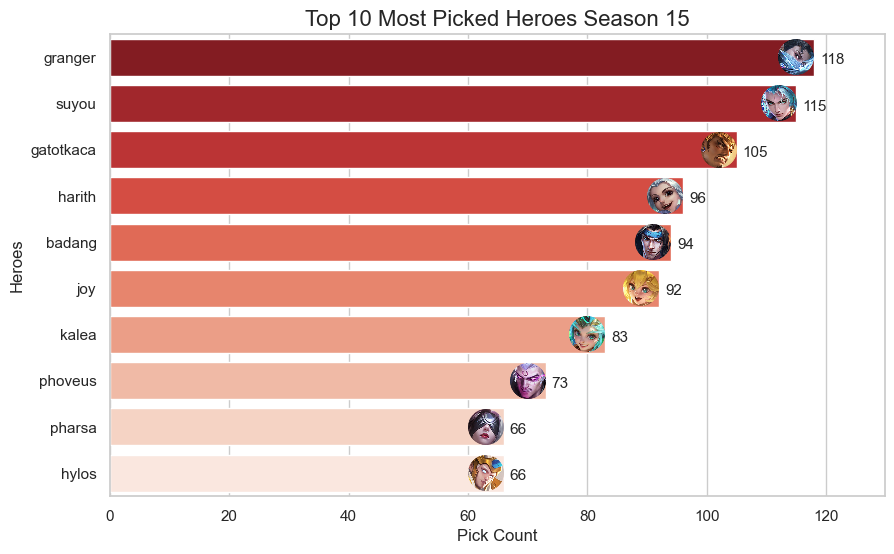

In [21]:
top_picked_s15_df = pick_df[pick_df["season"] == 15].nlargest(10, "pick_count").reset_index(drop=True)

plt.figure(figsize=(10, 6))
ax = sns.barplot(top_picked_s15_df, x="pick_count", y="hero", hue="hero", palette="Reds_r")
for i, row in top_picked_s15_df.iterrows():
  ax.text(row["pick_count"]+1, i+0.15, row["pick_count"], fontsize=11)
  img = plt.imread(f"../data/hero_images/{row['hero']}.png")
  im = OffsetImage(img, zoom=0.2)
  im.image.axes = ax
  ab = AnnotationBbox(im, (row["pick_count"], i), xybox=(-13, 0), frameon=False, xycoords="data", boxcoords="offset points", pad=0)
  ax.add_artist(ab)

plt.title("Top 10 Most Picked Heroes Season 15", fontsize=16)
plt.xlim(0, max(top_picked_s15_df["pick_count"]) * 1.1)
plt.xlabel("Pick Count")
plt.ylabel("Heroes")

plt.show()

### Hero Distribution

In [23]:
all_season_draft_steps_df = pd.read_csv("../data/processed/all_season_draft_steps.csv")
all_season_draft_steps_df.head()

,game_id,date,team_1,team_2,game_number,team_winner,patch_version,season,step_1,step_2,...,step_11,step_12,step_13,step_14,step_15,step_16,step_17,step_18,step_19,step_20
0,1,9-Aug-2024,tlid,fnoc,1,fnoc,1.9.06,14,fanny,chip,...,moskov,arlott,x.borg,joy,hylos,nolan,chou,julian,minotaur,harith
1,2,9-Aug-2024,fnoc,tlid,2,fnoc,1.9.06,14,zhuxin,chip,...,harith,arlott,terizla,hayabusa,hylos,luo yi,vexana,minotaur,thamuz,joy
2,3,9-Aug-2024,dewa,evos,1,dewa,1.9.06,14,terizla,chip,...,claude,vexana,minotaur,hayabusa,carmilla,alpha,ruby,julian,hylos,nolan
3,4,9-Aug-2024,dewa,evos,2,evos,1.9.06,14,terizla,chip,...,moskov,hylos,fanny,alpha,joy,hayabusa,guinevere,julian,x.borg,claude
4,5,9-Aug-2024,dewa,evos,3,dewa,1.9.06,14,zhuxin,chip,...,moskov,x.borg,fanny,luo yi,hayabusa,minotaur,guinevere,julian,paquito,novaria


In [41]:
s14_draft_steps = all_season_draft_steps_df[all_season_draft_steps_df["season"] == 14][['step_1', 'step_2', 'step_3', 'step_4', 'step_5',
                      'step_6', 'step_7', 'step_8', 'step_9', 'step_10', 'step_11', 'step_12', 'step_13', 'step_14',
                      'step_15', 'step_16', 'step_17', 'step_18', 'step_19', 'step_20']]

s14_long_df = s14_draft_steps.melt(var_name="step", value_name="hero")
s14_steps_count = s14_long_df.value_counts(["hero", "step"]).reset_index(name="count")
s14_pivot_df = s14_steps_count.pivot(index="hero", columns="step", values="count").fillna(0)
s14_pivot_df = s14_pivot_df[['step_1', 'step_2', 'step_3', 'step_4', 'step_5','step_6', 'step_7', 'step_8', 'step_9', 'step_10', 'step_11',
                             'step_12', 'step_13', 'step_14', 'step_15', 'step_16', 'step_17', 'step_18', 'step_19', 'step_20']]

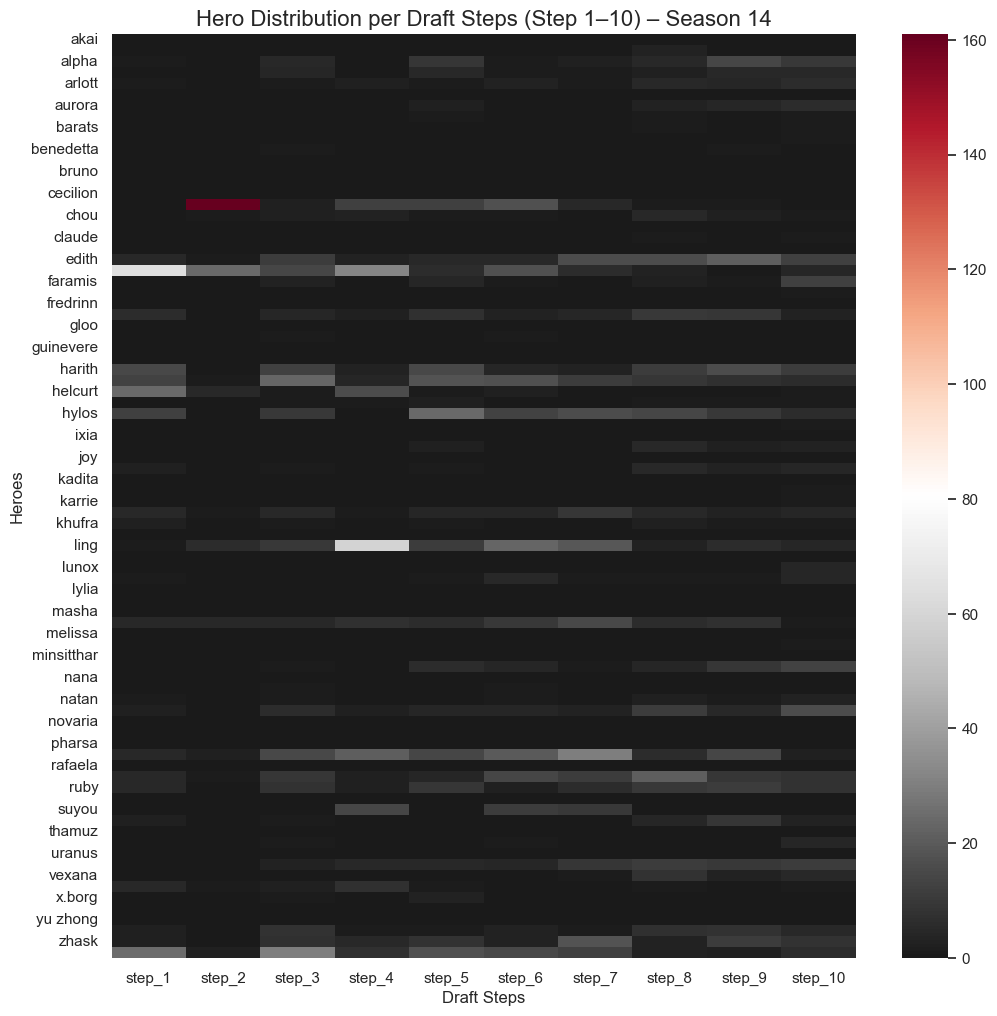

In [ ]:
plt.figure(figsize=(12, 12))
sns.heatmap(s14_pivot_df.loc[:, 'step_1':'step_10'], cmap="RdGy_r")
plt.title('Hero Distribution per Draft Steps (Step 1–10) – Season 14', fontsize=16)
plt.xlabel('Draft Steps')
plt.ylabel('Heroes')
plt.show()

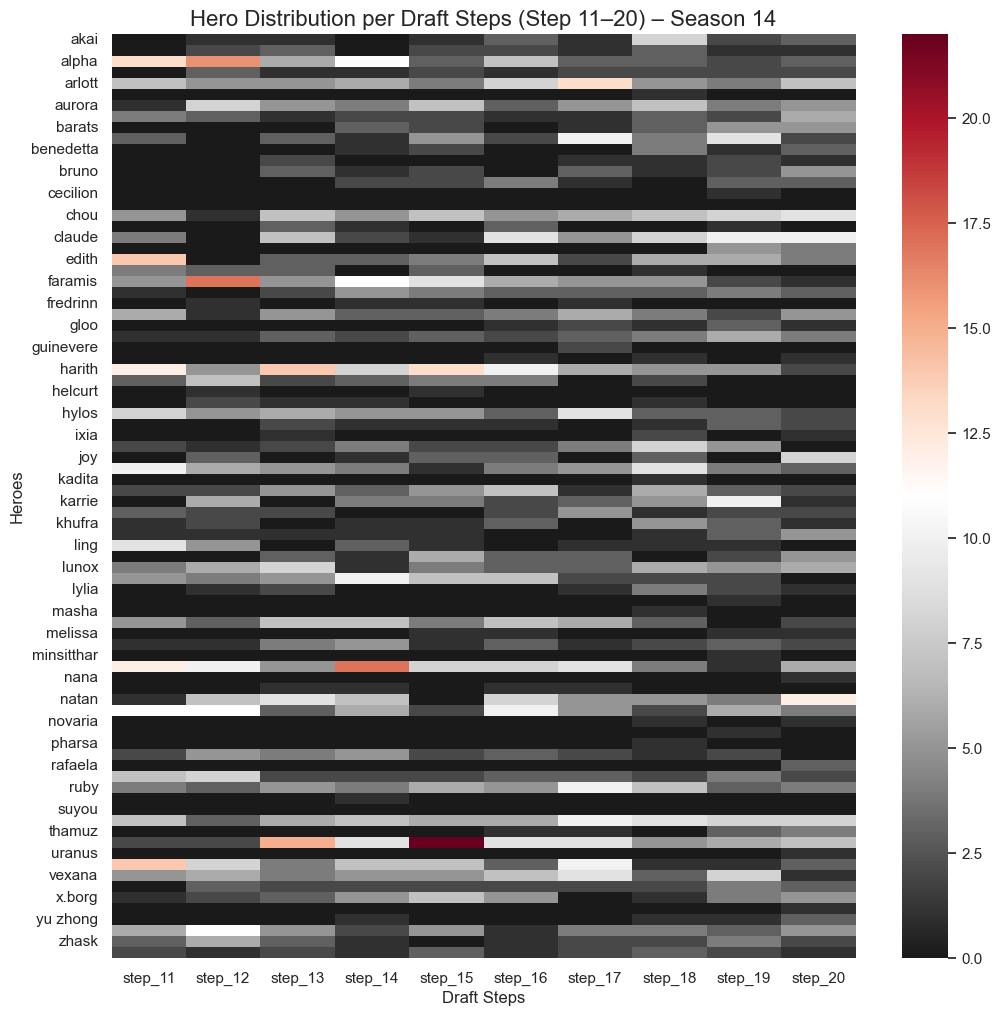

In [ ]:
plt.figure(figsize=(12, 12))
sns.heatmap(s14_pivot_df.loc[:, 'step_11':'step_20'], cmap="RdGy_r")
plt.title('Hero Distribution per Draft Steps (Step 11–20) – Season 14', fontsize=16)
plt.xlabel('Draft Steps')
plt.ylabel('Heroes')
plt.show()

In [46]:
s15_draft_steps = all_season_draft_steps_df[all_season_draft_steps_df["season"] == 15][['step_1', 'step_2', 'step_3', 'step_4', 'step_5',
                      'step_6', 'step_7', 'step_8', 'step_9', 'step_10', 'step_11', 'step_12', 'step_13', 'step_14',
                      'step_15', 'step_16', 'step_17', 'step_18', 'step_19', 'step_20']]

s15_long_df = s15_draft_steps.melt(var_name="step", value_name="hero")
s15_steps_count = s15_long_df.value_counts(["hero", "step"]).reset_index(name="count")
s15_pivot_df = s15_steps_count.pivot(index="hero", columns="step", values="count").fillna(0)
s15_pivot_df = s15_pivot_df[['step_1', 'step_2', 'step_3', 'step_4', 'step_5','step_6', 'step_7', 'step_8', 'step_9', 'step_10', 'step_11',
                             'step_12', 'step_13', 'step_14', 'step_15', 'step_16', 'step_17', 'step_18', 'step_19', 'step_20']]

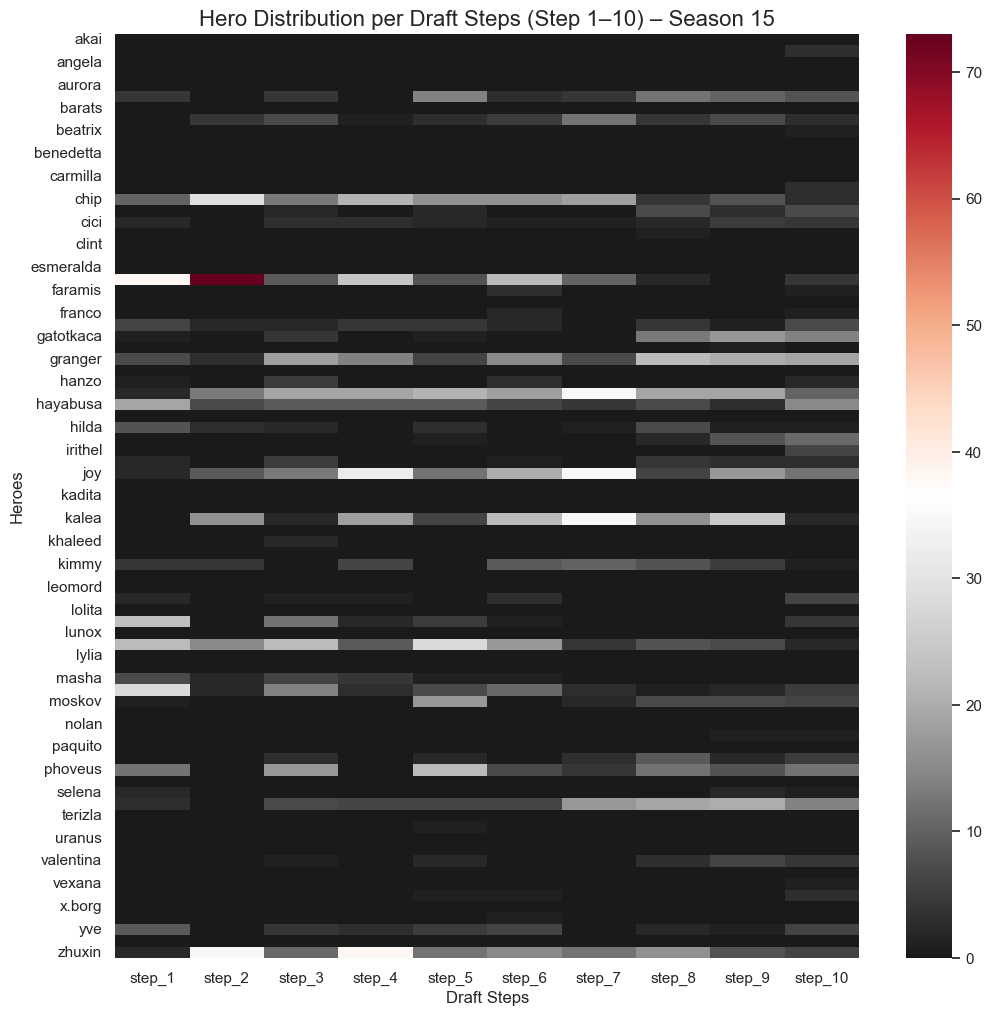

In [47]:
plt.figure(figsize=(12, 12))
sns.heatmap(s15_pivot_df.loc[:, 'step_1':'step_10'], cmap="RdGy_r")
plt.title('Hero Distribution per Draft Steps (Step 1–10) – Season 15', fontsize=16)
plt.xlabel('Draft Steps')
plt.ylabel('Heroes')
plt.show()

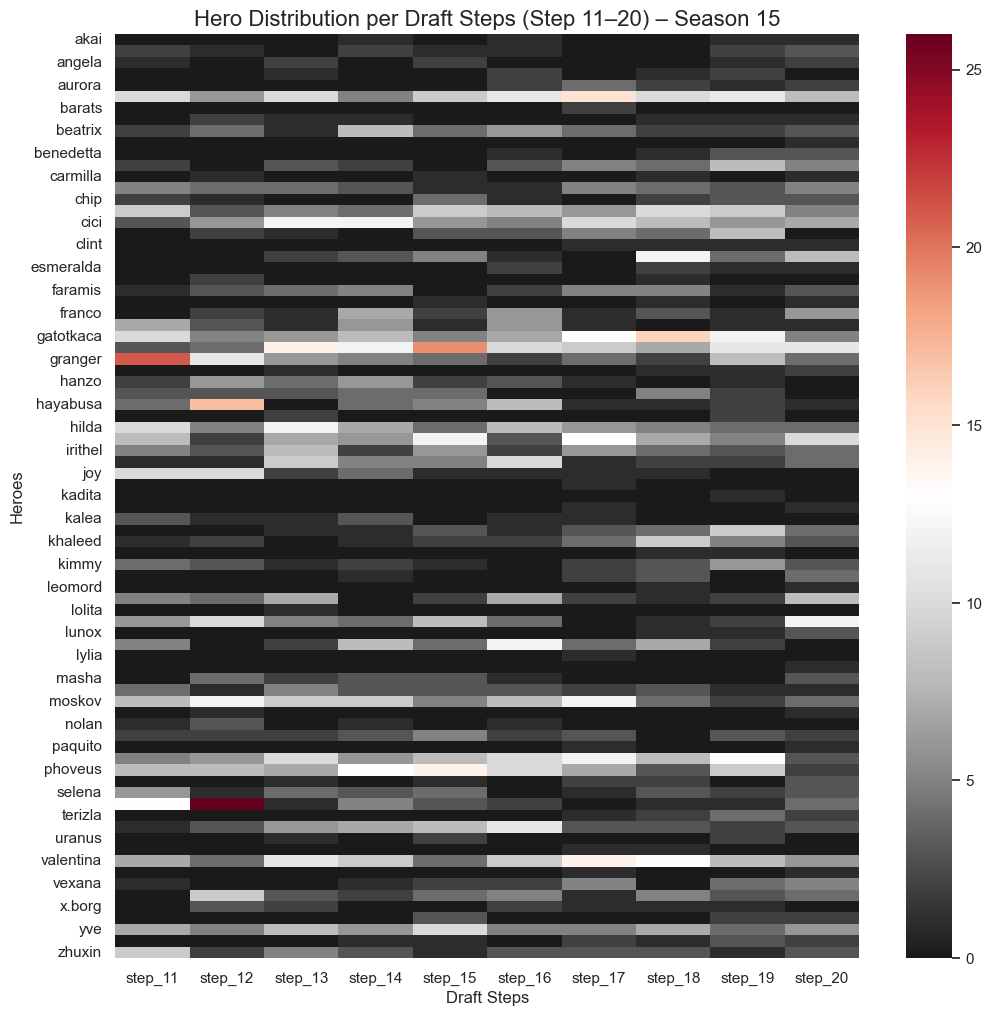

In [48]:
plt.figure(figsize=(12, 12))
sns.heatmap(s15_pivot_df.loc[:, 'step_11':'step_20'], cmap="RdGy_r")
plt.title('Hero Distribution per Draft Steps (Step 11–20) – Season 15', fontsize=16)
plt.xlabel('Draft Steps')
plt.ylabel('Heroes')
plt.show()